## ALERT Olek Zienkiewicz school on Constitutive Modelling of Geomaterials
### Hands-on: Data-driven discovery of constitutive equations (part II)

Authors: Enzo Louvard and Filippo Masi

#### Objectives

Learn how to perform regression to obtain an interpretable (hyper-elastic) constitutive model that best fits stress-strain data




### 1. Import necessary libraries

In [1]:
# Importing standard Python utilities
import os  # For handling directory and file operations
import pickle  # For saving and loading serialized objects (e.g., model parameters)
from datetime import datetime  # For timestamping saved results

# Importing numerical computing libraries
import numpy as np  # For array manipulations and numerical operations
import torch  # PyTorch for building and training machine learning models

# Importing visualization tools
import matplotlib.pyplot as plt  # Standard plotting library for visualizations
import matplotlib  # Additional customization for plotting styles
from matplotlib import rc
fontsize = 10
font = {'size'   : fontsize}
plt.rcParams['figure.facecolor']='white'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 0.6  # Set the axis line thickness
plt.rcParams['xtick.major.width'] = 0.2 # Major x-axis tick width
plt.rcParams['ytick.major.width'] = 0.2  # Major y-axis tick width
plt.rcParams['xtick.minor.width'] = 0.2  # Minor x-axis tick width
plt.rcParams['ytick.minor.width'] = 0.2  # Minor y-axis tick width


! pip install torchdiffeq
# Importing specific modules for NICE
from NICE_module.learning import (
    NICE,  # Model class
    slice_data,  # Function for splitting and processing data
    get_params  # Function to extract normalisation parameters
)

# Ensuring reproducibility by setting random seeds
np.random.seed(1)  # Seed for NumPy random number generator
torch.manual_seed(1)  # Seed for PyTorch random number generator

# Configuration: Setting verbosity levels for training
verbose_frequency = 10  # Print loss every `verbose_frequency` epochs
plotting_frequency = 100  # Plot training results every `plotting_frequency` epochs


/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


### 2. Load and preprocess Data

In [2]:
# Loading preprocessed dataset from a serialized file
with open('./dataset/sand/data_CID_raw', 'rb') as f:
    data = pickle.load(f)  # Load the dataset stored in a pickle file

# Unpacking the dataset into meaningful variables
strain, stress, density, time, lengths_path, path_label, number_protocol = data

# Define the dimensionality of the problem
dim = 2  # Assuming a 2D representation (e.g., strain and stress in two dimensions)

# Determine the number of time steps in the dataset
time_length = strain.shape[0]  # Extracting total number of time points from the strain array

# Setting the time step size (assuming normalized time between 0 and 1)
dt = 1 / time_length  # Uniform time discretization


#### 2.1 Define training, validation, and test data splits

In [3]:
# Defining protocol indices for dataset splits:
# Training protocols
n_train = np.array([0, 2, 2])  # Indices of data used for training
# Validation protocols
n_val = np.array([0, 1, 1])  # Indices of data used for validation
# Test protocols
n_test = np.array([0, 0, 0])  # Indices of data used for testing
# Combined training + validation protocols
n_train_val = np.array([0, 1, 2])  # Combined indices of training and validation data

# Slicing the data arrays to create training, validation, and test sets
# This ensures each subset contains the correct indices as defined above

# Strain data split
strain_train_val, strain_test = slice_data(strain, n_train_val, n_test)
# Stress data split
stress_train_val, stress_test = slice_data(stress, n_train_val, n_test)
# Density data split
density_train_val, density_test = slice_data(density, n_train_val, n_test)

####  2.2 Compute normalisation parameters 

In [4]:
# Extract parameters from the training dataset using the `get_params` function.
# These parameters may include mean, standard deviation, min/max values, or other statistics
# necessary for normalizing and standardizing the data.

# Extract parameters for the strain data (e.g., mean and standard deviation)
prm_strain = get_params(strain_train_val)

# Extract parameters for the stress data
# `vectorial_norm = False` suggests that we are not using vector normalization,
# possibly treating stress components separately.
prm_stress = get_params(stress_train_val, vectorial_norm=False)

# Extract parameters for the density data
prm_density = get_params(density_train_val)

### 3. Neural Integration for Constitutive Equations 

#### 3.1 Build neural network architectures and initialis NICE model

In [5]:
# Define parameters for the neural networks:
# - NNf: Neural network for the evolution equation
# - NNψ: Neural network for the free-energy function

# Format of parameters: 
# [input dimension, output dimension, [hidden layer sizes], activation function]

# Parameters for NNf (Evolution equation neural network)
NNf_params = [
    dim + 1,  # Input dimension (strain + density)
    dim,  # Output dimension (strain rate)
    [4 * (dim + 1), 4 * (dim + 1),  4 * (dim + 1)],  # Hidden layers
    'gelu'  # Activation function
]

# Parameters for NNψ (Free-energy function neural network)
NNψ_params = [
    dim + 1,  # Input dimension (strain + density)
    1,  # Output dimension (energy scalar)
    [2**4, 2**4, 2**4],  # Hidden layers (16 neurons per layer)
    'softplus'  # Activation function
]

# Grouped normalization parameters (strain, density, stress)
norm_params = [prm_strain, prm_density, prm_stress]

# Instantiate the NICE network with the specified parameters
NICE_network = NICE(NNf_params, NNψ_params, len(n_train_val), norm_params, dim)

#### 3.2 Convert data to pyTorch tensors and define time points

In [6]:
# Calculate discrete time points based on the time step parameter `dt`
t = torch.arange(0, 1.0, dt)  # Time points ranging from 0 to 1 with step size dt

# Convert training data (stress, strain, density) to PyTorch tensors
stress_train_val = torch.from_numpy(stress_train_val)  # Stress values for training
strain_train_val = torch.from_numpy(strain_train_val)  # Strain values for training
density_train_val = torch.from_numpy(density_train_val)  # Density values for training

# Convert test data (stress, strain, density) to PyTorch tensors
stress_test = torch.from_numpy(stress_test)  # Stress values for testing
epsilon_test = torch.from_numpy(strain_test)  # Strain values for testing
density_test = torch.from_numpy(density_test)  # Density values for testing

####  3.3 Generate interpolators for strain rates 

In [7]:
# Extract protocol indices for the training and validation set
id_protocol_train_val = np.arange(strain_train_val.shape[1])  # Protocol indices

# Initialize interpolation of incremental strain rates within the NICE network
NICE_network.init_interp(strain_train_val, t)

# Compute strain rate components using the interpolation functions
strain_rate_v = NICE_network.interp_dotev(t, id_protocol_train_val)  # Vertical component of strain rate
strain_rate_s = NICE_network.interp_dotes(t, id_protocol_train_val)  # Shear component of strain rate

# Combine the strain rate components along the last axis to form a full strain rate tensor
strain_rate = np.concatenate((strain_rate_v[:, :, None],  # Add extra dimension for compatibility
                              strain_rate_s[:, :, None]), axis=-1)

# Compute the normalization parameters for strain rate
NICE_network.prm_strain_rate = get_params(strain_rate)

# Reset training and validation protocols to their actual values
n_train = np.array([0, 2])  # Training set protocols
n_val = np.array([1])  # Validation set protocol

#### 3.4 Configure NICE network, optimiser, and loss function

In [8]:
# Configuring the NICE network parameters
NICE_network.solver = "dopri5"  # Adaptive Runge-Kutta (Dormand-Prince) solver
NICE_network.scheme = "forward"  # Forward integration scheme
NICE_network.step_size = dt  # Time step size
NICE_network.rtol = 1e-3  # Relative tolerance for ODE solver
NICE_network.atol = 1e-4  # Absolute tolerance for ODE solver

# Define optimizer, loss function, and training hyperparameters
optimizer = torch.optim.Adam(NICE_network.parameters(), lr=1e-3)  # Adam optimizer with learning rate 2e-3
n_epochs = 4000  # Number of training epochs
MSE = torch.nn.MSELoss()  # Mean Squared Error loss function

# Lists to store training and validation loss during training
training_loss_hist = []
validation_loss_hist = []

# Initial state variables for optimization
initial_density = density_train_val[0]  # Extract initial density from dataset
initial_density.requires_grad = True  # Allow gradient computation for optimization

initial_dissipation = torch.zeros_like(initial_density)  # Initialize dissipation rate to zero
initial_stress = stress_train_val[0]  # Extract initial stress from dataset

#### 3.5 Training Loop for the NICE Model

Epoch: 10 | Training Loss: 3.3563e+00 | validation loss: 9.4403e-01 | Elapsed Time Step: 0:00:04.485617
Epoch: 20 | Training Loss: 2.5218e+00 | validation loss: 3.6088e-01 | Elapsed Time Step: 0:00:04.709440
Epoch: 30 | Training Loss: 2.0188e+00 | validation loss: 2.4341e-01 | Elapsed Time Step: 0:00:04.958835
Epoch: 40 | Training Loss: 1.5251e+00 | validation loss: 2.2538e-01 | Elapsed Time Step: 0:00:04.862424
Epoch: 50 | Training Loss: 1.1054e+00 | validation loss: 2.3294e-01 | Elapsed Time Step: 0:00:04.699252
Epoch: 60 | Training Loss: 7.8522e-01 | validation loss: 2.4235e-01 | Elapsed Time Step: 0:00:04.807378
Epoch: 70 | Training Loss: 5.5859e-01 | validation loss: 2.5979e-01 | Elapsed Time Step: 0:00:04.809097
Epoch: 80 | Training Loss: 4.8395e-01 | validation loss: 2.9785e-01 | Elapsed Time Step: 0:00:04.983305
Epoch: 90 | Training Loss: 4.3909e-01 | validation loss: 3.1638e-01 | Elapsed Time Step: 0:00:06.455015
Epoch: 100 | Training Loss: 3.8342e-01 | validation loss: 2.9270

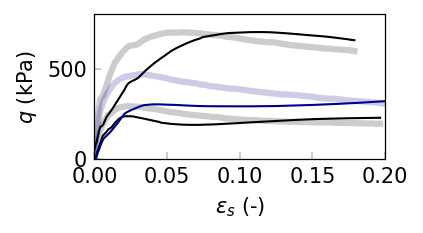

Epoch: 110 | Training Loss: 3.3853e-01 | validation loss: 2.9215e-01 | Elapsed Time Step: 0:00:05.553043
Epoch: 120 | Training Loss: 2.7685e-01 | validation loss: 2.5880e-01 | Elapsed Time Step: 0:00:05.469994
Epoch: 130 | Training Loss: 2.3826e-01 | validation loss: 2.7828e-01 | Elapsed Time Step: 0:00:05.214406
Epoch: 140 | Training Loss: 1.9908e-01 | validation loss: 2.5682e-01 | Elapsed Time Step: 0:00:05.019120
Epoch: 150 | Training Loss: 1.6358e-01 | validation loss: 2.4812e-01 | Elapsed Time Step: 0:00:04.754878
Epoch: 160 | Training Loss: 1.3034e-01 | validation loss: 2.1179e-01 | Elapsed Time Step: 0:00:04.718268
Epoch: 170 | Training Loss: 1.0829e-01 | validation loss: 2.5887e-01 | Elapsed Time Step: 0:00:05.040227
Epoch: 180 | Training Loss: 8.7374e-02 | validation loss: 2.2469e-01 | Elapsed Time Step: 0:00:04.958522
Epoch: 190 | Training Loss: 7.4783e-02 | validation loss: 2.3405e-01 | Elapsed Time Step: 0:00:04.844770
Epoch: 200 | Training Loss: 6.6661e-02 | validation los

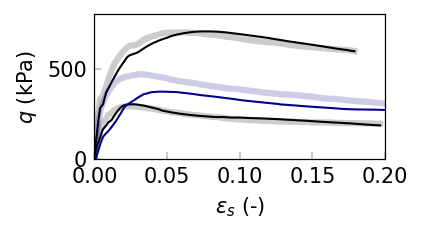

Epoch: 210 | Training Loss: 5.9397e-02 | validation loss: 2.3369e-01 | Elapsed Time Step: 0:00:05.299276
Epoch: 220 | Training Loss: 4.4398e-02 | validation loss: 2.1169e-01 | Elapsed Time Step: 0:00:05.050352
Epoch: 230 | Training Loss: 5.4847e-02 | validation loss: 1.8397e-01 | Elapsed Time Step: 0:00:04.832372
Epoch: 240 | Training Loss: 4.4554e-02 | validation loss: 1.7810e-01 | Elapsed Time Step: 0:00:04.871160
Epoch: 250 | Training Loss: 4.1896e-02 | validation loss: 1.6491e-01 | Elapsed Time Step: 0:00:04.861897
Epoch: 260 | Training Loss: 5.1088e-02 | validation loss: 1.4153e-01 | Elapsed Time Step: 0:00:04.956923
Epoch: 270 | Training Loss: 3.8988e-02 | validation loss: 1.8153e-01 | Elapsed Time Step: 0:00:05.027117
Epoch: 280 | Training Loss: 3.7474e-02 | validation loss: 1.6218e-01 | Elapsed Time Step: 0:00:04.917299
Epoch: 290 | Training Loss: 3.5587e-02 | validation loss: 1.3569e-01 | Elapsed Time Step: 0:00:04.993667
Epoch: 300 | Training Loss: 3.0483e-02 | validation los

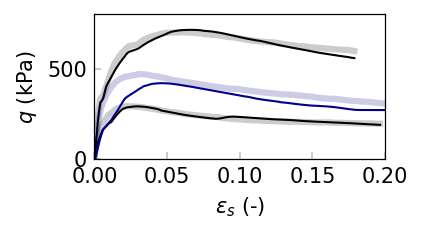

Epoch: 310 | Training Loss: 3.1414e-02 | validation loss: 1.3229e-01 | Elapsed Time Step: 0:00:05.197342
Epoch: 320 | Training Loss: 3.3887e-02 | validation loss: 1.1484e-01 | Elapsed Time Step: 0:00:05.411741
Epoch: 330 | Training Loss: 2.5719e-02 | validation loss: 8.7753e-02 | Elapsed Time Step: 0:00:05.327719
Epoch: 340 | Training Loss: 2.7373e-02 | validation loss: 7.7308e-02 | Elapsed Time Step: 0:00:05.056702
Epoch: 350 | Training Loss: 2.4761e-02 | validation loss: 7.9482e-02 | Elapsed Time Step: 0:00:05.216895
Epoch: 360 | Training Loss: 2.4945e-02 | validation loss: 6.7829e-02 | Elapsed Time Step: 0:00:05.015773
Epoch: 370 | Training Loss: 1.9712e-02 | validation loss: 5.7292e-02 | Elapsed Time Step: 0:00:04.979991
Epoch: 380 | Training Loss: 1.8927e-02 | validation loss: 5.2850e-02 | Elapsed Time Step: 0:00:04.925508
Epoch: 390 | Training Loss: 1.8851e-02 | validation loss: 4.9280e-02 | Elapsed Time Step: 0:00:05.116988
Epoch: 400 | Training Loss: 1.9310e-02 | validation los

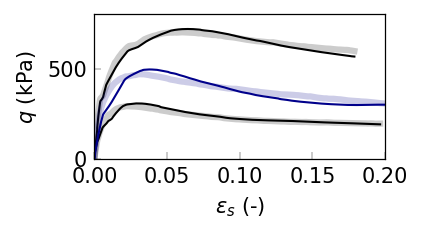

Epoch: 410 | Training Loss: 2.2108e-02 | validation loss: 4.1650e-02 | Elapsed Time Step: 0:00:05.120252
Epoch: 420 | Training Loss: 2.6258e-02 | validation loss: 4.1755e-02 | Elapsed Time Step: 0:00:05.091633
Epoch: 430 | Training Loss: 1.8070e-02 | validation loss: 5.6741e-02 | Elapsed Time Step: 0:00:05.132536
Epoch: 440 | Training Loss: 1.8944e-02 | validation loss: 4.7494e-02 | Elapsed Time Step: 0:00:05.191015
Epoch: 450 | Training Loss: 1.8497e-02 | validation loss: 5.5288e-02 | Elapsed Time Step: 0:00:05.380213
Epoch: 460 | Training Loss: 1.2560e-02 | validation loss: 4.9624e-02 | Elapsed Time Step: 0:00:05.490726
Epoch: 470 | Training Loss: 1.5647e-02 | validation loss: 4.9173e-02 | Elapsed Time Step: 0:00:05.342313
Epoch: 480 | Training Loss: 1.7441e-02 | validation loss: 4.8158e-02 | Elapsed Time Step: 0:00:05.530886
Epoch: 490 | Training Loss: 1.6957e-02 | validation loss: 4.2024e-02 | Elapsed Time Step: 0:00:05.092241
Epoch: 500 | Training Loss: 1.1674e-02 | validation los

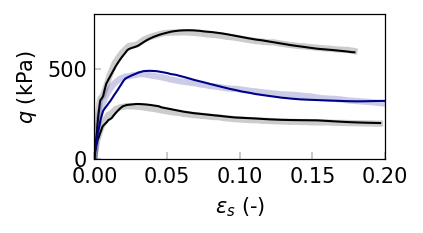

Epoch: 510 | Training Loss: 1.4828e-02 | validation loss: 6.0259e-02 | Elapsed Time Step: 0:00:05.967035
Epoch: 520 | Training Loss: 3.0656e-02 | validation loss: 4.1145e-02 | Elapsed Time Step: 0:00:05.474670
Epoch: 530 | Training Loss: 1.1496e-02 | validation loss: 5.6682e-02 | Elapsed Time Step: 0:00:05.835363
Epoch: 540 | Training Loss: 1.1800e-02 | validation loss: 4.1415e-02 | Elapsed Time Step: 0:00:05.844410
Epoch: 550 | Training Loss: 1.1713e-02 | validation loss: 4.2658e-02 | Elapsed Time Step: 0:00:05.658397
Epoch: 560 | Training Loss: 8.3041e-03 | validation loss: 4.2813e-02 | Elapsed Time Step: 0:00:06.279788
Epoch: 570 | Training Loss: 8.0290e-03 | validation loss: 4.1197e-02 | Elapsed Time Step: 0:00:05.996692
Epoch: 580 | Training Loss: 7.8979e-03 | validation loss: 4.8789e-02 | Elapsed Time Step: 0:00:06.035960
Epoch: 590 | Training Loss: 7.6430e-03 | validation loss: 4.9262e-02 | Elapsed Time Step: 0:00:05.962088
Epoch: 600 | Training Loss: 8.3926e-03 | validation los

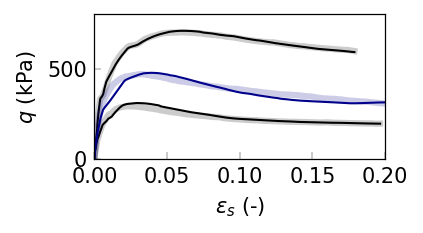

Epoch: 610 | Training Loss: 1.1757e-02 | validation loss: 5.8951e-02 | Elapsed Time Step: 0:00:05.736066
Epoch: 620 | Training Loss: 6.0001e-03 | validation loss: 4.3626e-02 | Elapsed Time Step: 0:00:05.699649
Epoch: 630 | Training Loss: 9.3812e-03 | validation loss: 6.0821e-02 | Elapsed Time Step: 0:00:05.588291
Epoch: 640 | Training Loss: 1.4131e-02 | validation loss: 7.3172e-02 | Elapsed Time Step: 0:00:05.546613
Epoch: 650 | Training Loss: 1.2564e-02 | validation loss: 4.4074e-02 | Elapsed Time Step: 0:00:05.660532
Epoch: 660 | Training Loss: 5.9617e-03 | validation loss: 6.7559e-02 | Elapsed Time Step: 0:00:05.591414
Epoch: 670 | Training Loss: 8.2329e-03 | validation loss: 8.0153e-02 | Elapsed Time Step: 0:00:05.731252
Epoch: 680 | Training Loss: 7.5490e-03 | validation loss: 7.8684e-02 | Elapsed Time Step: 0:00:05.801178
Epoch: 690 | Training Loss: 2.2431e-02 | validation loss: 9.4078e-02 | Elapsed Time Step: 0:00:05.783295
Epoch: 700 | Training Loss: 5.2434e-03 | validation los

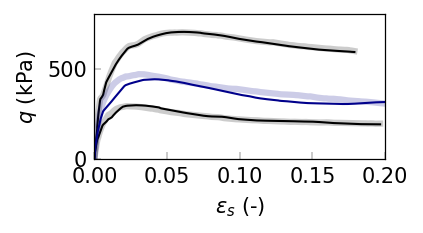

Epoch: 710 | Training Loss: 8.4426e-03 | validation loss: 5.2889e-02 | Elapsed Time Step: 0:00:05.653655
Epoch: 720 | Training Loss: 6.6959e-03 | validation loss: 5.9308e-02 | Elapsed Time Step: 0:00:05.552020
Epoch: 730 | Training Loss: 9.5262e-03 | validation loss: 6.2322e-02 | Elapsed Time Step: 0:00:05.313384
Epoch: 740 | Training Loss: 4.1354e-03 | validation loss: 8.0048e-02 | Elapsed Time Step: 0:00:05.465688
Epoch: 750 | Training Loss: 8.7699e-03 | validation loss: 1.0759e-01 | Elapsed Time Step: 0:00:05.560067
Epoch: 760 | Training Loss: 1.4190e-02 | validation loss: 1.2356e-01 | Elapsed Time Step: 0:00:05.511231
Epoch: 770 | Training Loss: 5.4050e-03 | validation loss: 9.8845e-02 | Elapsed Time Step: 0:00:05.642265
Epoch: 780 | Training Loss: 6.4134e-03 | validation loss: 1.0158e-01 | Elapsed Time Step: 0:00:05.454085
Epoch: 790 | Training Loss: 4.7577e-03 | validation loss: 8.6097e-02 | Elapsed Time Step: 0:00:05.800488
Epoch: 800 | Training Loss: 4.1236e-03 | validation los

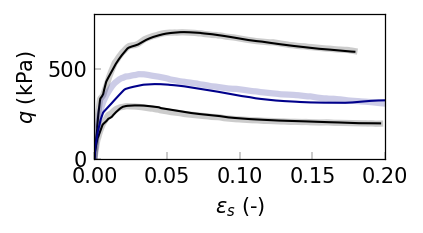

Epoch: 810 | Training Loss: 4.6196e-03 | validation loss: 8.5019e-02 | Elapsed Time Step: 0:00:05.758675
Epoch: 820 | Training Loss: 4.3599e-03 | validation loss: 1.2176e-01 | Elapsed Time Step: 0:00:05.458066
Epoch: 830 | Training Loss: 4.5192e-03 | validation loss: 1.2175e-01 | Elapsed Time Step: 0:00:05.492720
Epoch: 840 | Training Loss: 8.1504e-03 | validation loss: 1.3433e-01 | Elapsed Time Step: 0:00:05.702910
Epoch: 850 | Training Loss: 9.0692e-03 | validation loss: 1.6657e-01 | Elapsed Time Step: 0:00:08.270306
Epoch: 860 | Training Loss: 5.3492e-03 | validation loss: 1.4064e-01 | Elapsed Time Step: 0:00:11.206591
Epoch: 870 | Training Loss: 4.9424e-03 | validation loss: 1.5374e-01 | Elapsed Time Step: 0:00:11.796889
Epoch: 880 | Training Loss: 5.6685e-03 | validation loss: 1.3787e-01 | Elapsed Time Step: 0:00:11.275777
Epoch: 890 | Training Loss: 5.2538e-03 | validation loss: 1.3694e-01 | Elapsed Time Step: 0:00:11.810580
Epoch: 900 | Training Loss: 4.5942e-03 | validation los

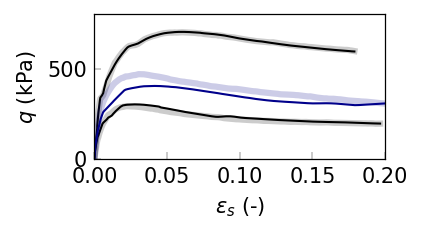

Epoch: 910 | Training Loss: 3.3135e-03 | validation loss: 1.3716e-01 | Elapsed Time Step: 0:00:05.443130
Epoch: 920 | Training Loss: 3.6778e-03 | validation loss: 1.4254e-01 | Elapsed Time Step: 0:00:05.287098
Epoch: 930 | Training Loss: 1.1252e-02 | validation loss: 1.8077e-01 | Elapsed Time Step: 0:00:05.052766
Epoch: 940 | Training Loss: 3.0095e-03 | validation loss: 1.4528e-01 | Elapsed Time Step: 0:00:05.284091
Epoch: 950 | Training Loss: 4.8041e-03 | validation loss: 1.2648e-01 | Elapsed Time Step: 0:00:05.384520
Epoch: 960 | Training Loss: 3.7437e-03 | validation loss: 1.4864e-01 | Elapsed Time Step: 0:00:05.378431
Epoch: 970 | Training Loss: 3.1334e-03 | validation loss: 1.4225e-01 | Elapsed Time Step: 0:00:05.260012
Epoch: 980 | Training Loss: 4.3505e-03 | validation loss: 1.1708e-01 | Elapsed Time Step: 0:00:05.182619
Epoch: 990 | Training Loss: 2.8547e-03 | validation loss: 1.4233e-01 | Elapsed Time Step: 0:00:05.136865
Epoch: 1000 | Training Loss: 3.0866e-03 | validation lo

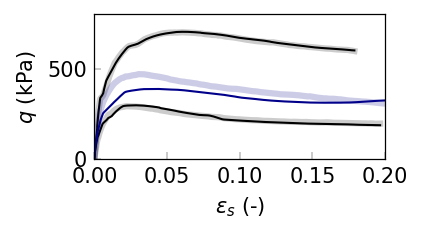

Epoch: 1010 | Training Loss: 2.6249e-03 | validation loss: 1.5687e-01 | Elapsed Time Step: 0:00:05.408226
Epoch: 1020 | Training Loss: 2.7939e-03 | validation loss: 1.6825e-01 | Elapsed Time Step: 0:00:04.845448
Epoch: 1030 | Training Loss: 4.7990e-03 | validation loss: 2.0384e-01 | Elapsed Time Step: 0:00:05.267686


In [ ]:
# Track starting time for performance monitoring
time_now = datetime.now()
t_0 = datetime.now()

# Training loop
for epoch in range(1, n_epochs):
    # Zero gradients before backward pass
    optimizer.zero_grad()

    # Extract initial elastic strain (denormalized)
    initial_epsilon_el = NICE_network.DeNormalize(NICE_network.initial_elastic_strain,
                                                  NICE_network.prm_strain_elastic)

    # Define the initial conditions for integration
    initial_conditions = torch.cat((initial_epsilon_el, initial_density, initial_dissipation), -1)

    # Compute the initial stress prediction from the NICE model
    stress_e, p_T, predicted_initial_stress = NICE_network.stress([initial_epsilon_el, initial_density])

    # Forward pass: Integrate the ODE system using the NICE network
    predictions = NICE_network.integrate(initial_conditions, t, id_protocol_train_val)
    predicted_svars, predicted_stress, predicted_dissipation = predictions

    # Compute the dissipation rate (time derivative of dissipation)
    predicted_dissipation_rate = (predicted_dissipation[1:] - predicted_dissipation[:-1]) / dt

    # Compute the training loss components

    # 1. Stress loss: Difference between predicted and actual stress values (normalized)
    training_loss_stress = MSE(NICE_network.Normalize(predicted_stress[:, n_train], prm_stress),
                               NICE_network.Normalize(stress_train_val[:, n_train], prm_stress))

    # 2. Initial stress loss: Ensures initial stress predictions match the dataset
    training_loss_r0 = MSE(NICE_network.Normalize(predicted_initial_stress, prm_stress),
                           NICE_network.Normalize(initial_stress, prm_stress))

    # 3. Dissipation loss: Ensures physically consistent dissipation behavior
    norm_dissipation_rate = torch.std(predicted_dissipation_rate).detach()
    training_loss_dissipation = MSE(NICE_network.MacaulayBrackets(-predicted_dissipation_rate) / norm_dissipation_rate,
                                    torch.zeros_like(predicted_dissipation_rate))

    # Total training loss
    training_loss = (training_loss_stress + training_loss_r0 + training_loss_dissipation)

    # Backward pass and optimization step
    training_loss.backward()
    optimizer.step()

    # Compute validation loss
    validation_loss = MSE(NICE_network.Normalize(predicted_stress[:, n_val], prm_stress),
                          NICE_network.Normalize(stress_train_val[:, n_val], prm_stress))
    
    # Extract loss values for monitoring
    training_loss_value = training_loss.item()
    validation_loss_value = validation_loss.item()
    
    # Store loss values for plotting
    training_loss_hist.append(training_loss_value)
    validation_loss_hist.append(validation_loss_value)

    # Print loss every 'verbose_frequency' epochs
    if not epoch % verbose_frequency:
        print(f"Epoch: {epoch}"
              + f" | Training Loss: {training_loss_value:.4e}"
              + f" | validation loss: {validation_loss_value:.4e}"
              + f" | Elapsed Time Step: {datetime.now() - time_now}"
              )
        time_now = datetime.now()

    # Plot q-eps_s every 'plotting_frequency' epochs
    if not epoch % plotting_frequency:
        figure, ax = plt.subplots(dpi=150, figsize=(2.5, 1.25))
    
        # Loop over protocols in the training set
        for i, protocol in enumerate(n_train):
            # Plot ground truth
            ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
                    stress_train_val[:, protocol, 1].detach().numpy(),
                    linewidth=3, alpha=0.2, color='black',
                    label="Ground Truth" if i == 0 else "")
    
            # Plot model-predicted stress-strain curve
            ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
                    predicted_stress[:, protocol, 1].detach().numpy(),
                    linewidth=1, color='black',
                    label="Predicted" if i == 0 else "")

        # Loop over protocols in the validation set
        for i, protocol in enumerate(n_val):
            # Plot ground truth
            ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
                    stress_train_val[:, protocol, 1].detach().numpy(),
                    linewidth=3, alpha=0.2, color='darkblue',
                    label="Ground Truth" if i == 0 else "")
    
            # Plot model-predicted stress-strain curve
            ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
                    predicted_stress[:, protocol, 1].detach().numpy(),
                    linewidth=1, color='darkblue',
                    label="Predicted" if i == 0 else "")
    
        ax.set_ylim(0, 800)  # Limit for q (kPa)
        ax.set_xlim(0, 0.2)  # Limit for strain
        ax.set_ylabel('$q$ (kPa)')  # Stress variable label
        ax.set_xlabel(r'$\varepsilon_s$ (-)')  # Strain variable label    
        plt.show()

#### 3.6 Loss versus epochs

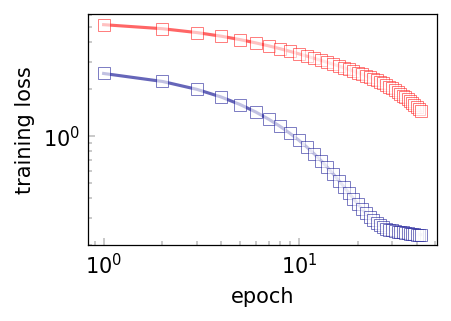

In [11]:
figure, ax = plt.subplots(dpi=150, figsize=(3, 2.))

# Log-log plot of training loss history
ax.loglog(np.arange(1, len(training_loss_hist) + 1, 1), # epochs
          training_loss_hist,
          marker='s', markersize=6, markeredgecolor='red', markeredgewidth=0.4, markerfacecolor='white',  
          linestyle='-', alpha = 0.6, color='red')
# Log-log plot of validation loss history
ax.loglog(np.arange(1, len(validation_loss_hist) + 1, 1), # epochs
          validation_loss_hist,
          marker='s', markersize=6, markeredgecolor='darkblue', markeredgewidth=0.4, markerfacecolor='white',  # Hollow red markers
          linestyle='-', alpha = 0.6, color='darkblue')  # Solid black line connecting points
# Axis labels
ax.set_xlabel("epoch")
ax.set_ylabel("training loss")
# Show plot
plt.show()

### 4. Inference

#### 4.1 Predict the initial conditions for the elastic strain given the stress state

In [13]:
from scipy.optimize import root
# Solve for initial elastic strain using a root-finding method
solution = root(NICE_network.find_elastic_strain,
                args=([initial_density, initial_stress.reshape(-1, 2)]),
                x0=np.zeros((len(n_train_val), 2)),  # Initial guess for elastic strain
                tol=1e-12)  # High precision tolerance

# Convert solution to PyTorch tensor
norm_initial_elastic_strain = torch.from_numpy(solution.x.reshape(-1, 2))

# De-normalizing the computed elastic strain to its physical scale
initial_elastic_strain = NICE_network.DeNormalize(norm_initial_elastic_strain, NICE_network.prm_strain_elastic)

#### 4.2 Predict the material response under strain-driven protocol

In [15]:
# Creating the full state variable input for the NICE network
initial_conditions = torch.cat((initial_elastic_strain, initial_density, initial_dissipation), -1)

# Predicting the stress evolution with the NICE network
predictions = NICE_network.integrate(initial_conditions, t, id_protocol_train_val)

# Extracting the predicted state variables, stress, and dissipation
predicted_svars, predicted_stress, predicted_dissipation = predictions

#### 4.3 Predictions versus real experiments (stress-strain response)

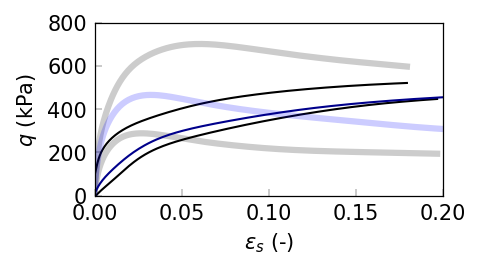

In [17]:
figure, ax = plt.subplots(dpi=150, figsize=(3, 1.5))
    
# Loop over protocols in the training set
for i, protocol in enumerate(n_train):
    # Plot ground truth
    ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
            stress_train_val[:, protocol, 1].detach().numpy(),
            linewidth=3, alpha=0.2, color='black',
            label="Ground Truth" if i == 0 else "")

    # Plot model-predicted stress-strain curve
    ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
            predicted_stress[:, protocol, 1].detach().numpy(),
            linewidth=1, color='black',
            label="Predicted" if i == 0 else "")

# Loop over protocols in the validation set
for i, protocol in enumerate(n_val):
    # Plot ground truth
    ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
            stress_train_val[:, protocol, 1].detach().numpy(),
            linewidth=3, alpha=0.2, color='blue',
            label="Ground Truth" if i == 0 else "")

    # Plot model-predicted stress-strain curve
    ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
            predicted_stress[:, protocol, 1].detach().numpy(),
            linewidth=1, color='darkblue',
            label="Predicted" if i == 0 else "")

ax.set_ylim(0, 800)  # Limit for q (kPa)
ax.set_xlim(0, 0.2)  # Limit for strain
ax.set_ylabel(r'$q$ (kPa)')  # Stress variable label
ax.set_xlabel(r'$\varepsilon_s$ (-)')  # Strain variable label    
plt.show()

### 4.4 Thermodynamics consistency: dissipation and dissipation rate

0
1
0


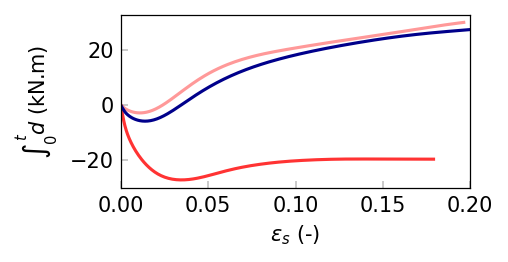

In [19]:
figure, ax = plt.subplots(dpi=150, figsize=(3, 1.5))
# Loop through training protocols
for i, protocol in enumerate(n_train):
    print(i)
    ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
            predicted_dissipation[:, protocol, 0].detach().numpy(),
            alpha=0.4*i+0.4, color='red',
            label="Predicted Dissipation" if i == 0 else "")  
for i, protocol in enumerate(n_val):
    print(i)
    ax.plot(strain_train_val[:, protocol, 1].detach().numpy(),
            predicted_dissipation[:, protocol, 0].detach().numpy(),
            alpha=1, color='darkblue',
            label="Predicted Dissipation" if i == 0 else "")  

ax.set_xlim(0, 0.2)
ax.set_ylabel('$\int_0^t d $ (kN.m)')
ax.set_xlabel(r'$\varepsilon_s$ (-)')
plt.show()

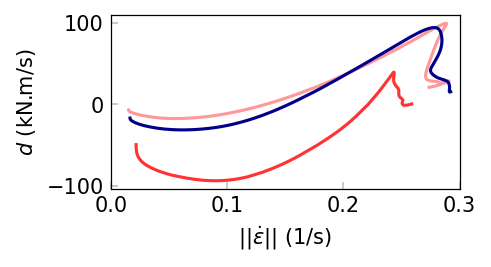

In [27]:
predicted_dissipation_rate = (predicted_dissipation[1:] - predicted_dissipation[:-1]) / dt
figure, ax = plt.subplots(dpi=150, figsize=(3, 1.5))
# Loop through training protocols
for i, protocol in enumerate(n_train):
    ax.plot(np.linalg.norm(strain_rate[:-1, protocol],axis=-1,ord=None),
            predicted_dissipation_rate[:, protocol, 0].detach().numpy(),
            alpha=0.4*i+0.4, color='red',
            label="Predicted Dissipation" if i == 0 else "") 
# Loop through validation protocols
for i, protocol in enumerate(n_val):
    ax.plot(np.linalg.norm(strain_rate[:-1, protocol],axis=-1,ord=None),
            predicted_dissipation_rate[:, protocol, 0].detach().numpy(),
            alpha=1, color='darkblue',
            label="Predicted Dissipation" if i == 0 else "") 
ax.set_xlim(0, 0.3)
ax.set_ylabel('$d$ (kN.m/s)')
ax.set_xlabel(r'$|| \dot{\varepsilon}||$ (1/s)')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=943eba7c-6248-4f0d-a7d4-57f7be1179ac' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>